# Pivotal Life Sciences Interview - Daniel Massop

In this document, we will explore a dataset containing information on the subreddit askscience and analyze and model out what determines a successful post. Two potential response variables are provided, score and upvote_ratio. Score is calculated as upvotes minus downvotes, whereas upvote ratio is calculated as the ratio of upvotes over upvotes plus downvotes. 

The main sections of this notebook are 

### 1) Initial Data loads, package loads, and Data Exploration
### 2) Data Cleaning
### 3) Data Modeling
### 4) Conclusion

Three approaches are taking for modeling. They are vocabulary present in the form of token counts, text readability and post tags, glove embeddings. Motiviation and results of each type will be explored later in the notebook. 

## Initial Data loads, package loads, and Data Exploration

In [1]:
import pandas as pd
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import spacy
import numpy as np
import matplotlib.pyplot as plt
import re
from textstat.textstat import textstatistics

from scipy.stats import linregress
from sklearn.linear_model import Ridge
from collections import Counter

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
nlp = spacy.load('en_core_web_lg')

all_stopwords = nlp.Defaults.stop_words

In [63]:
reddit_data = pd.read_csv('https://raw.githubusercontent.com/Pivotal-Life-Sciences-DS/daniel-takehome/main/askscience_data.csv', 
                          index_col = 0)
print(reddit_data.shape)
reddit_data.head()

(4205, 8)


,title,body,tag,datetime,author,score,upvote_ratio,url
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...


The abve is the form of the raw data. At the outset, we can see that certain posts are tagged as META and/or attributed to the moderators. As these posts are not in the spirit of the problem prompt, they will be removed. Upon intial inspection, there is also one tag with leading whitespace which will be reformatted for the tags. While I did look at both upvote ratios and scores as candidate response variables, we will focus more on score as I consider it to be more representative of a succesful post and the net attention that a post generates.

In [64]:
reddit_data['score'].mean()

3730.471105826397

In [65]:
reddit_data['score'].std()

5577.606541400174

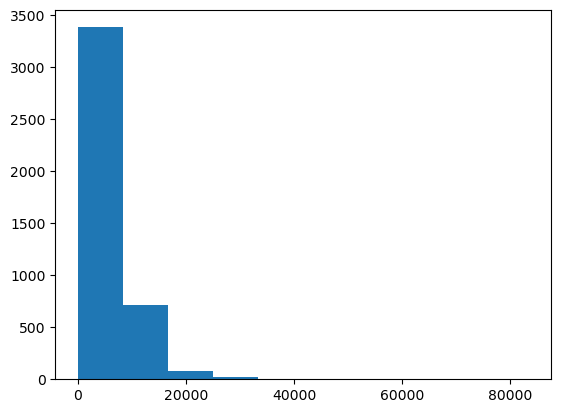

In [66]:
plt.hist(reddit_data['score'])
plt.show()

## Note
Upon initial inspection, we can see that score has a classic right tail distribution and quite a lot of variance as the score's deviation is significantly larger than the mean. This does bode poorly for our ability to accurately predict the score, but we shall do our best!

In [67]:
reddit_data['tag'] = reddit_data['tag'].fillna('None')
np.unique(reddit_data['tag'])

array(['  Linguistics', 'Anthropology', 'Archaeology', 'Astronomy',
       'Biology', 'CERN AMA', 'COVID-19', 'Chemistry', 'Computing',
       'Dog Cognition AMA', 'Earth Sciences',
       'Earth Sciences and Biology', 'Ecology', 'Economics',
       'Engineering', 'First image of a black hole', 'Food', 'Human Body',
       'Interdisciplinary', 'Linguistics', 'META', 'Materials Science',
       'Mathematics', 'Medicine', 'Meta', 'Neuroscience', 'None',
       'Paleontology', 'Physics', 'Planetary Sci.', 'Political Science',
       'Psychology', 'Social Science'], dtype=object)

In [68]:
reddit_data = reddit_data[(reddit_data['tag'] != 'META') 
                          & (reddit_data['tag'] != 'Meta') 
                          & (reddit_data['author'] != 'AskScienceModerator')]
reddit_data['tag'][reddit_data['tag'] == '  Linguistics'] = 'Linguistics'

In [69]:
tags_row_counts = pd.DataFrame(reddit_data['tag'].value_counts())
tags_performance = reddit_data.groupby('tag')[['score','upvote_ratio']].mean()
tags_df = pd.merge(tags_row_counts,tags_performance,left_index = True, right_index = True)

In [70]:
tags_df.sort_values('score', ascending=False)

,tag,score,upvote_ratio
Ecology,2,9213.500000,0.920000
Anthropology,23,6975.869565,0.832609
Dog Cognition AMA,1,6880.000000,0.850000
CERN AMA,1,6776.000000,0.880000
Earth Sciences and Biology,2,6567.500000,0.920000
Computing,57,6202.596491,0.782982
Linguistics,36,5648.000000,0.821667
Engineering,186,5054.822581,0.793172
Earth Sciences,312,4684.298077,0.805256
Human Body,457,4348.722101,0.814748


## Observation 1
Having a relevant tag is important. Not too much to say beyond the obvious, but posts missing a tag ('None' in the above table) are signficantly worse in terms of overall score and upvote ratio than all other tags with non-trivial sample size. There does appear to be a bit of spread in the other tags as well, ie people appear to not like math questions, so tag will be later used as a feature.

In [71]:
print('Null body post count is ' + str(len(reddit_data[reddit_data['body'].isnull()].index)))

Null body post count is 1712


In [72]:
reddit_data['empty_body_bool'] = 0
reddit_data.loc[reddit_data['body'].isnull(),'empty_body_bool'] = 1

null_body_row_counts = pd.DataFrame(reddit_data['empty_body_bool'].value_counts())
null_body_performance = reddit_data.groupby('empty_body_bool')[['score','upvote_ratio']].mean()
null_body_df = pd.merge(null_body_row_counts,null_body_performance,left_index = True, right_index = True)

null_body_df

,empty_body_bool,score,upvote_ratio
0,2445,2035.921472,0.723767
1,1712,5986.524533,0.822996


## Observation 2
Interestingly, whereas not having a tag boded very poorly for a post, not having any text in the body of the post (empty body bool == 1 in the table) actually is positive for performance in both score and upvote ratio. This could suggest that people prefer concise, organized questions free of fluff. As such we will explore title and body length as potential features.

In [73]:
reddit_data['body'] = reddit_data['body'].replace(np.nan, '', regex=True)

In [74]:
reddit_data['title_length'] = reddit_data.apply(lambda x: len(x['title']), axis = 1)
reddit_data['body_length'] = reddit_data.apply(lambda x: len(x['body']), axis = 1)

slope: 25.410744, intercept: 1256.723579


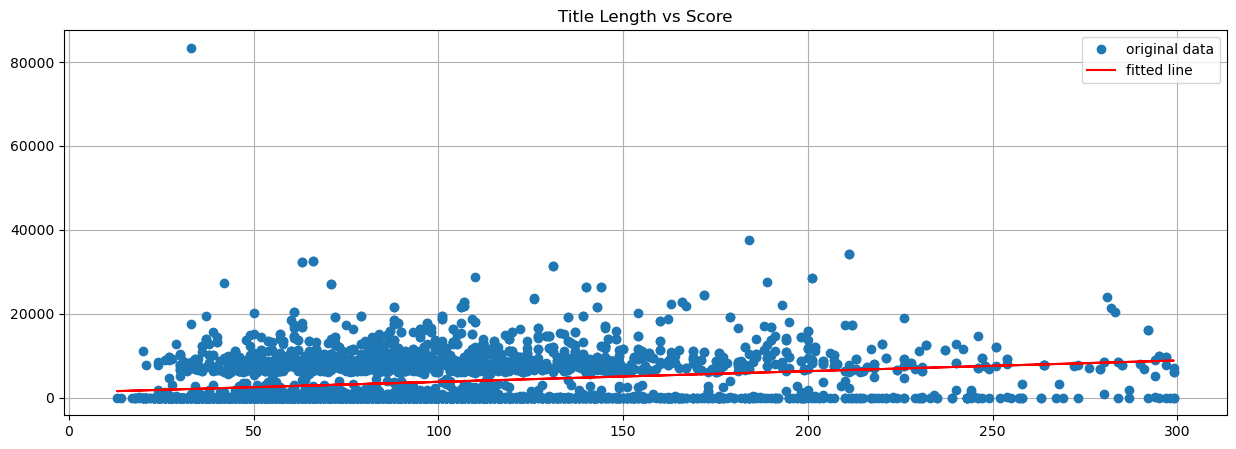

In [75]:
x = reddit_data['title_length']
y = reddit_data['score']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f, intercept: %f" % (slope, intercept))

plt.figure(figsize=(15, 5))
plt.title("Title Length vs Score")
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

slope: -2.913275, intercept: 4325.938431


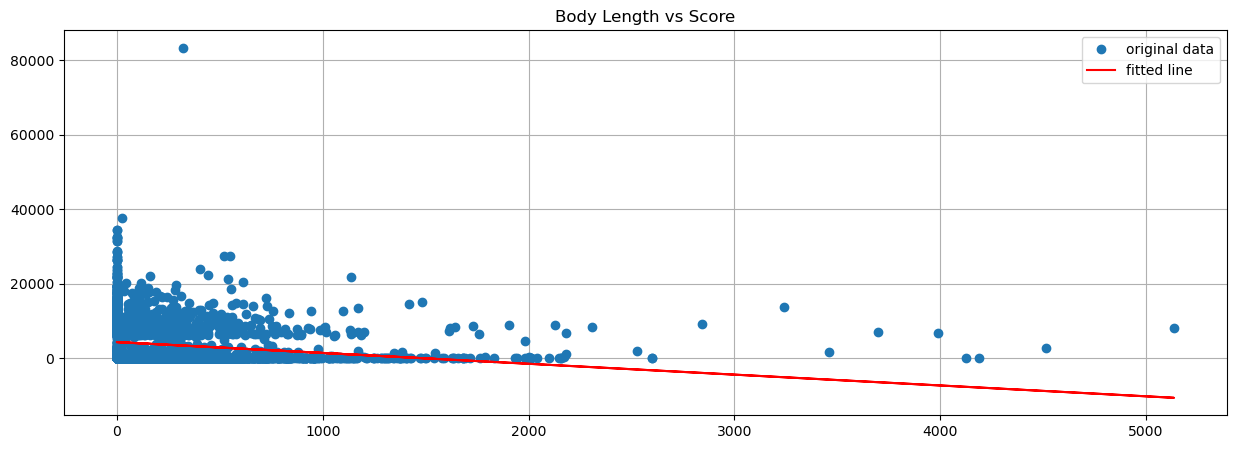

In [78]:
x = reddit_data['body_length']
y = reddit_data['score']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f, intercept: %f" % (slope, intercept))

plt.figure(figsize=(15, 5))
plt.title("Body Length vs Score")

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

slope: -0.138630, intercept: 2089.563136


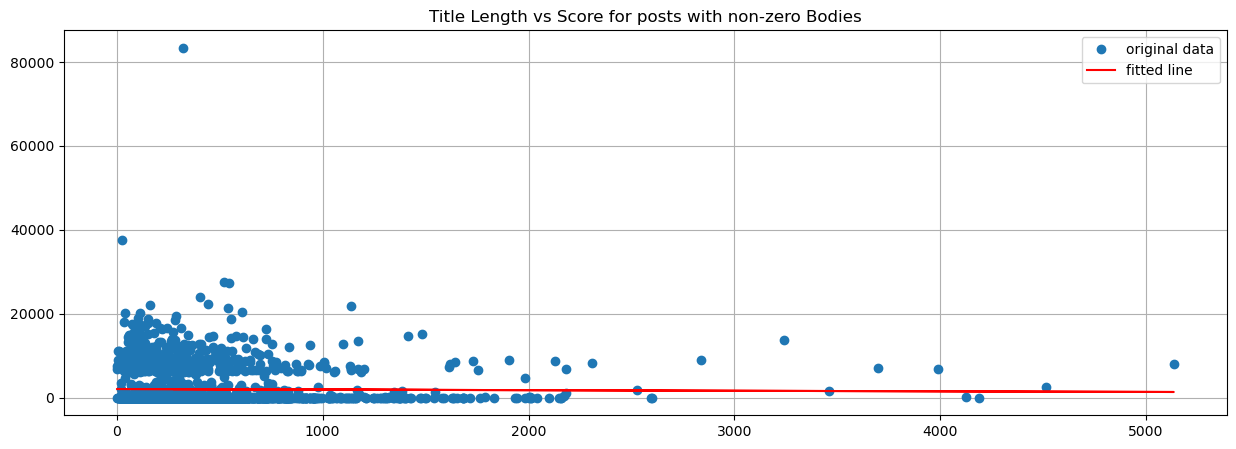

In [79]:
x = reddit_data['body_length'][reddit_data['body_length'] != 0]
y = reddit_data['score'][reddit_data['body_length'] != 0]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f, intercept: %f" % (slope, intercept))

plt.figure(figsize=(15, 5))
plt.title("Title Length vs Score for posts with non-zero Bodies")

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Data Cleaning
Upon inspection of the data, many of the posts contain edits that a user makes after the intial post. One such example is below. This text becomes present in the post only after the post becomes successful, and as such will be removed.

In [81]:
reddit_data[reddit_data.index == 43]['body'][43]

"Did I ask a stupid question?\n\nEdit: wow, didn't expect this to blow up like this, ty all for your explanations, this is much clearer now. I didn't get why we would use a unit that describes a quantity when we already have a quantity related unit that is the mass, especially when we know how to weight things. Thank you again for your help, I really didn't expect the reddit community to be so supportive."

In [82]:
# Cleaned text to be used for the models later, in this block we are combining the titles and bodies,
# converting to lower case, removing punctuation and removing newline characters.
# This cleaned text will be the raw input for the token count based model.
reddit_data['cleaned_text'] = reddit_data['title'].str.lower() + ' ' + reddit_data['body'].str.lower()
reddit_data['cleaned_text'] = reddit_data['cleaned_text'].apply(lambda x: x.split('edit')[0])

reddit_data['cleaned_text'] = reddit_data['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]','',x)) #removes punctuation
reddit_data['cleaned_text'] = reddit_data['cleaned_text'].apply(lambda x: x.replace('\n',' '))

reddit_data['cleaned_text_length'] = reddit_data['cleaned_text'].apply(lambda x: len(x))

In [83]:
# Same as above, but only focusing on the body rather than the body + title. For use in the below graph.
reddit_data['cleaned_body'] = reddit_data['body'].str.lower()
reddit_data['cleaned_body'] = reddit_data['cleaned_body'].apply(lambda x: x.split('edit')[0])

reddit_data['cleaned_body'] = reddit_data['cleaned_body'].apply(lambda x: re.sub(r'[^\w\s]','',x))
reddit_data['cleaned_body'] = reddit_data['cleaned_body'].apply(lambda x: x.replace('\n',' '))

reddit_data['cleaned_body_length'] = reddit_data['cleaned_body'].apply(lambda x: len(x))

slope: -0.634497, intercept: 2134.162425


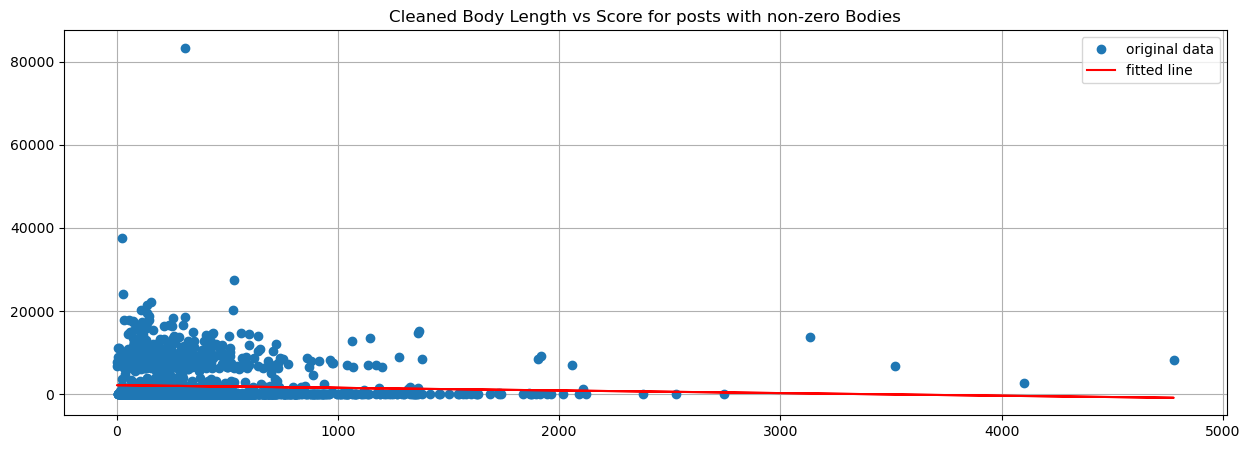

In [86]:
x = reddit_data['cleaned_body_length'][reddit_data['cleaned_body_length'] != 0]
y = reddit_data['score'][reddit_data['cleaned_body_length'] != 0]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f, intercept: %f" % (slope, intercept))

plt.figure(figsize=(15, 5))
plt.title("Cleaned Body Length vs Score for posts with non-zero Bodies")

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Observation 3
Upon removing the edits, the slope of body length to score trendline goes from -0.14 to -0.63. This 4x change in magnitude strongly supports the idea that removing the 'edit text' is a good idea and that having a long body is detrimental to a successful post.

slope: 0.000021, intercept: 0.714154


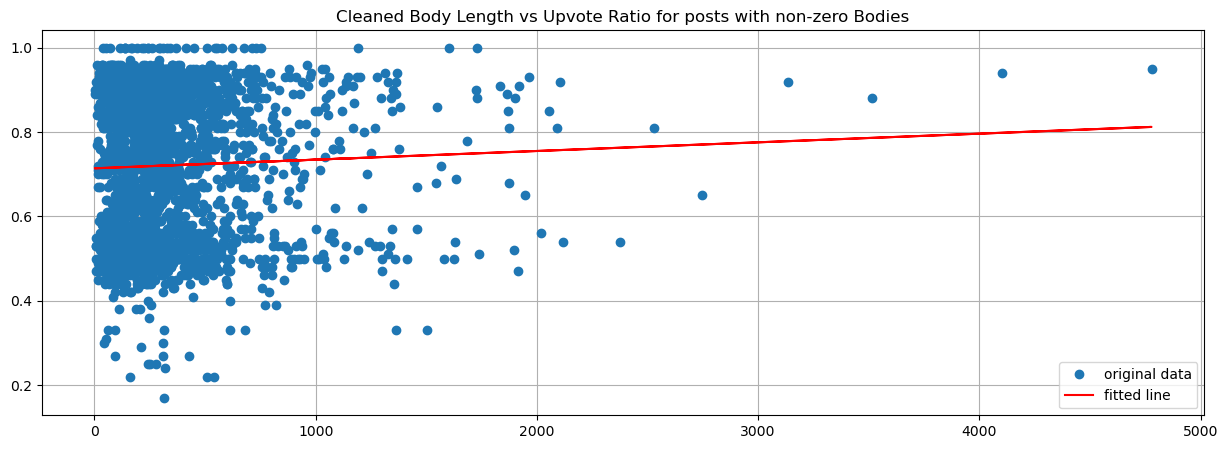

In [87]:
x = reddit_data['cleaned_body_length'][reddit_data['cleaned_body_length'] != 0]
y = reddit_data['upvote_ratio'][reddit_data['cleaned_body_length'] != 0]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f, intercept: %f" % (slope, intercept))

plt.figure(figsize=(15, 5))
plt.title("Cleaned Body Length vs Upvote Ratio for posts with non-zero Bodies")

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Note
Interestingly, while the slope of the trendline for the cleaned body length vs score is negative, the trendline against upvote ratio is actually positive. This could mean that its simply more difficult for long posts to get attention as people don't want to read them, but if they do they still can be quite successful. The slope is very close to 0 however. Lastly before beginning the modeling process, we will create a masked version of the tags that group the rare values (present in under 1% of rows) into an other category. This may potentially generate some additional accuracy for the model, but at the very least it will prevent overfitting.

In [88]:
tag_counts = pd.DataFrame(reddit_data['tag'].value_counts()).reset_index()
# df is 4157 rows at this point, filtering for values present in at least 1% of them, ie tag count < 42
filtered_tag_counts = tag_counts[tag_counts['tag'] < 42] 
reddit_data['masked_tag'] = reddit_data['tag'].mask(reddit_data['tag'].isin(filtered_tag_counts['index']), 'Other')

## Modeling - Token Counts
Next we will create a count of tokens accross all of the posts. This means that we will essentially generate a dataframe where each column is a unique word and the value present is the count of that word in each post. Stop-words will be ignored as they are going to be common across all posts and including them will only generate noise. The motivation for this type of model will be to determine if certain vocabulary being used is indicative of a good post.

In [89]:
reddit_data['spacy_doc'] = reddit_data.apply(lambda x: nlp(x['cleaned_text']), axis = 1)
reddit_data['tokens'] = reddit_data['spacy_doc'].apply(lambda x: [token.text for token in x])
reddit_data['tokens'] = reddit_data['tokens'].apply(lambda x: [token for token in x if not token in all_stopwords])
reddit_data['token_counts'] = reddit_data.apply(lambda row: Counter(row['tokens']), axis=1)

In [90]:
#score appears as a token so renaming the response variable to avoid confusion
reddit_data.rename(columns = {'score':'response_variable_score'}, inplace = True) 

In [91]:
tokens_final_df = pd.concat([reddit_data[['response_variable_score','upvote_ratio']], 
                             reddit_data['token_counts'].apply(pd.Series)], axis=1)
tokens_final_df = tokens_final_df.fillna(0)
tokens_final_df.head()

,response_variable_score,upvote_ratio,post,viral,cough,worse,better,tldr,upper,respiratory,...,throatcheek,kit,county,restrain,drivethrough,stasis,accumulation,factorsproteins,xii,lightenergy
0,1343.0,0.93,6.0,5.0,8.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,426.0,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,48.0,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.0,0.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,84.0,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
X = tokens_final_df.loc[:, (tokens_final_df.columns != 'response_variable_score') 
                        & (tokens_final_df.columns != 'upvote_ratio')]

In [93]:
y_score = tokens_final_df['response_variable_score']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y_score, test_size=0.25, random_state=42)

In [28]:
clf_tokens_ridge_score = Ridge(alpha=35.0)
clf_tokens_ridge_score.fit(X_train, y_train)
y_pred = clf_tokens_ridge_score.predict(X_test)
results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('ridge regression, alpha 35, RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('ridge regression, alpha 35, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

ridge regression, alpha 35, RMSE is 5306.692915718553
ridge regression, alpha 35, MAE is 4181.944367113165


In [95]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.05,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(X_train, y_train)

y_pred = reg_tokens_score.predict(X_test)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting RMSE is 5159.618281757474
gradient boosting, MAE is 4090.4206427703157


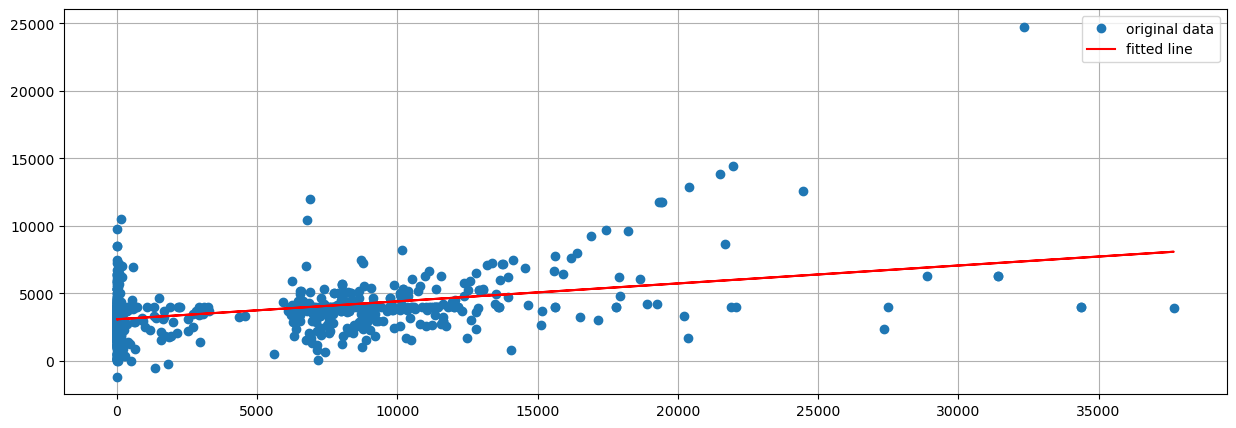

In [31]:
x = results['actual']
y = results['predicted']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.figure(figsize=(15, 5))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Model Results
The ridge regression and gradient boosting model perform relatively similarly. As we will see later, this style is the worst of the 3 archetypes. Being that the root mean square error (RMSE) is higher than the mean absolute error (MAE), it means our errors are dominated by comparitively fewer, particularly large errors. As such it may be helpful to perform a log transform on the response variable and see how that affects the accuracy metrics.

In [32]:
y_score_log_transform = y_score.copy()
y_score_log_transform.loc[y_score_log_transform == 0] = 1
y_score_log_transform = np.log(y_score_log_transform)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_score_log_transform, test_size=0.25, random_state=42)

In [34]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.05,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(X_train, y_train)

y_pred = reg_tokens_score.predict(X_test)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting, transformed y RMSE is ' + str(((np.exp(results.predicted) - np.exp(results.actual)) ** 2).mean() ** .5))
print('gradient boosting, transformed y MAE is ' + str(np.mean(np.abs(np.exp(results.actual) - np.exp(results.predicted)))))

gradient boosting, transformed y RMSE is 6581.807446745518
gradient boosting, transformed y MAE is 3635.2083090522933


## Model Results
As expected, the MAE improves while the RMSE gets worse. This model is still performaning worse than the later options and as such we will move on.

## Modeling - Readability
This next model will focus on evaluating the readability of a post as a feature. Readability here can be broadly defined as how easy it is for a user to process the question in terms of how large the words in the post are, how long the sentences are and such. We will also include encoded post tags as a bit of a throw-in as they make more sense to include here than in the other models. We will calculate 4 metrics for readability, Flesch-Reading, Gunning-Fog, Smog Index, and Dale-Chall Formula. These metrics are based on linguistics research. Further reading on these metrics can be found below.

https://www.geeksforgeeks.org/readability-index-pythonnlp/

https://python.engineering/readability-index-pythonnlp/

This first step will be to calculate the necessary input values to then calculate the final metrics. Once we have that generateing the metrics is just a matter of plugging the values into the appropriate formulas. The idea behind this model being that people are more likely to respond and react to language that is simple and easy to follow.

In [99]:
reddit_data['readability_text'] = reddit_data['title'] + ' ' + reddit_data['body']
reddit_data['readability_text'] = reddit_data['readability_text'].apply(lambda x: re.split("edit", x, 
                                                                                           flags=re.IGNORECASE)[0])

In [111]:
reddit_data['readability_doc'] = reddit_data.apply(lambda x: nlp(x['readability_text']), axis = 1)

In [112]:
reddit_data['sentences'] = reddit_data['readability_doc'].apply(lambda x: list(x.sents))

In [113]:
def word_count(sentences):
    words = 0
    #count words in each sentence
    for sentence in sentences:
        words += len([token for token in sentence])
    return words

reddit_data['word_count'] = reddit_data['sentences'].apply(lambda x: word_count(x))

In [114]:
reddit_data['sentence_count'] = reddit_data['sentences'].apply(lambda x: len(x))

In [115]:
reddit_data['avg_sentence_length'] = reddit_data['word_count'] / reddit_data['sentence_count']

In [116]:
def calculate_syllable_count(sentences):
        
    syllables = 0
    
    for sentence in sentences:
                
        token_list = [token for token in sentence]
                
        for token in token_list:
            
            syllables += textstatistics().syllable_count(str(token))
                
    return syllables

reddit_data['syllable_count'] = reddit_data['sentences'].apply(lambda x: calculate_syllable_count(x))

In [117]:
reddit_data['syllables_per_word'] = reddit_data['syllable_count'] / reddit_data['word_count']

In [118]:
def difficult_words(sentences):
     
    # Find all words in the text
    words = []
    for sentence in sentences:
        words += [str(token) for token in sentence]
 
    # difficult words are those with syllables >= 2
    # stop words removes a list of common words
    diff_words_set = set()
     
    for word in words:
        syllable_count = textstatistics().syllable_count(word)
        
        if word not in all_stopwords and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)

reddit_data['difficult_words'] = reddit_data['sentences'].apply(lambda x: difficult_words(x))

In [119]:
def poly_syllable_count(sentences):
    
    # Find all words in the text
    count = 0
    words = []

    for sentence in sentences:
        words += [token for token in sentence]
    
    #Poly syllables are words with at least 3 syllables
    for word in words:
        syllable_count = textstatistics().syllable_count(str(word))
        if syllable_count >= 3:
            count += 1
    return count

reddit_data['poly_syllables'] = reddit_data['sentences'].apply(lambda x: poly_syllable_count(x))

In [120]:
reddit_data['flesch_reading_ease'] = 206.835 - (1.015 * reddit_data['avg_sentence_length']) -\
          (84.6 * reddit_data['syllables_per_word'])

reddit_data['gunning_fog'] = (0.4 * reddit_data['avg_sentence_length'] + \
                              ((reddit_data['difficult_words'] / reddit_data['word_count'] * 100)+ 5))

reddit_data['smog_index'] = (1.043 * (30*(reddit_data['poly_syllables'] / reddit_data['sentence_count']))**0.5) + 3.1291

reddit_data['easy_words'] = reddit_data['word_count'] - reddit_data['difficult_words']
reddit_data['easy_words_percent'] = reddit_data['easy_words'] / reddit_data['word_count']
reddit_data['dale_chall_score_raw'] = (0.1579 * reddit_data['difficult_words']) + (0.0496 * reddit_data['avg_sentence_length'])

reddit_data['dale_chall_score_bonus'] = 0
reddit_data.loc[reddit_data['difficult_words'] > 5,'dale_chall_score_bonus'] = 3.6365
reddit_data['dale_chall_score'] = reddit_data['dale_chall_score_raw'] + reddit_data['dale_chall_score_bonus']

In [121]:
x = reddit_data[['flesch_reading_ease', 'gunning_fog', 'smog_index',
                 'dale_chall_score','title_length','cleaned_body_length', 'masked_tag']]
y = reddit_data['response_variable_score']

x = x.reset_index(drop=True)
y = y.reset_index(drop=True)

one_hot_tags = pd.get_dummies(x['masked_tag'])

x = pd.merge(x, one_hot_tags, left_index = True, right_index = True)

x = x.drop(columns = 'masked_tag')

In [122]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [50]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(X_train, y_train)

y_pred = reg_tokens_score.predict(X_test)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting RMSE is 5018.448465997236
gradient boosting, MAE is 3423.004064261202


In [123]:
from sklearn.ensemble import RandomForestRegressor

# create the model, train it, print scores
clf = RandomForestRegressor()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('Random Forest Readability and Tags, RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('Random Forest Readability and Tags, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

Random Forest Readability and Tags, RMSE is 4832.595272315055
Random Forest Readability and Tags, MAE is 3276.242295169414


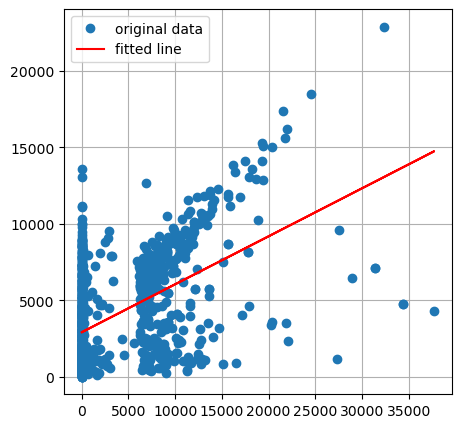

In [124]:
x = results['actual']
y = results['predicted']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.figure(figsize=(5, 5))

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Model Results
The gradient boosting and random forest booth outperform the token count based model, and the random forest model is the best performing in both metrics. This suggests that the metrics are at least more useful than the vocabulary based model and the readability has a bit of predictive power. There is a clear tightening around the desired x = y line that shows the model having effectiveness.

## Model- Glove Embeddings
The last model we will try will be a glove based model. The first step for this one will be to encode the tokens using the below glove file. From there we can then create the glove based model. Glove is an industry standard with an excellent track record in understanding and making predictions based on text.

In [52]:
glove_file = 'C:/Users/danie/Downloads/glove.6B/glove.6B.100d.txt'
word2vec_output_file = glove_file + '.word2vec'

In [53]:
glove2word2vec(glove_file, word2vec_output_file)

C:\Users\danie\AppData\Local\Temp\ipykernel_8556\1647202812.py:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


(400000, 100)

In [96]:
class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")
        
    def fit(self, data):
        pass

    def transform(self, data):
        # determine the dimensionality of vectors by getting one random one
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            
            for word in tokens:
                if word not in all_stopwords:
                    try:
                        # throws KeyError if word not found
                        vec = self.word_vectors.get_vector(word)
                        vecs.append(vec)
                        m += 1
                    except KeyError:
                        pass
                
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
                
            else:
                emptycount += 1
            n += 1
            
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [97]:
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [100]:
X = reddit_data['readability_text']
y = reddit_data['response_variable_score']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [102]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 9 / 3117
Number of samples with no words found: 7 / 1040


In [59]:
from sklearn.ensemble import RandomForestRegressor

# create the model, train it, print scores
clf = RandomForestRegressor()

clf.fit(Xtrain, Ytrain)

y_pred = clf.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('Random Forest Glove Embeddings, RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('Random Forest Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

Random Forest Glove Embeddings, RMSE is 4899.176319280092
Random Forest Glove Embeddings, MAE is 3606.783443841579


In [103]:
from sklearn.ensemble import RandomForestRegressor

# create the model, train it, print scores
clf = RandomForestRegressor()

clf.fit(Xtrain, Ytrain)

y_pred = clf.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('Random Forest Glove Embeddings, RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('Random Forest Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

Random Forest Glove Embeddings, RMSE is 4791.20977833821
Random Forest Glove Embeddings, MAE is 3550.0545219462388


In [104]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.10,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(Xtrain, Ytrain)

y_pred = reg_tokens_score.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting Glove Embeddings RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting Glove Embeddings RMSE is 4765.979781356425
gradient boosting Glove Embeddings, MAE is 3160.931470660749


In [105]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.08,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(Xtrain, Ytrain)

y_pred = reg_tokens_score.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting Glove Embeddings RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting Glove Embeddings RMSE is 4712.103424474795
gradient boosting Glove Embeddings, MAE is 3236.939314869983


In [106]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.12,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(Xtrain, Ytrain)

y_pred = reg_tokens_score.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting Glove Embeddings RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting Glove Embeddings RMSE is 4634.3982083424435
gradient boosting Glove Embeddings, MAE is 3083.632820048155


In [107]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.15,
    "loss": "squared_error",
}

reg_tokens_score = ensemble.GradientBoostingRegressor(**params)
reg_tokens_score.fit(Xtrain, Ytrain)

y_pred = reg_tokens_score.predict(Xtest)

results = pd.DataFrame(y_pred,y_test).reset_index()
results.columns = ['actual','predicted']

print('gradient boosting Glove Embeddings RMSE is ' + str(((results.predicted - results.actual) ** 2).mean() ** .5))
print('gradient boosting Glove Embeddings, MAE is ' + str(np.mean(np.abs(results.actual - results.predicted))))

gradient boosting Glove Embeddings RMSE is 4680.085121684461
gradient boosting Glove Embeddings, MAE is 3033.621801443838


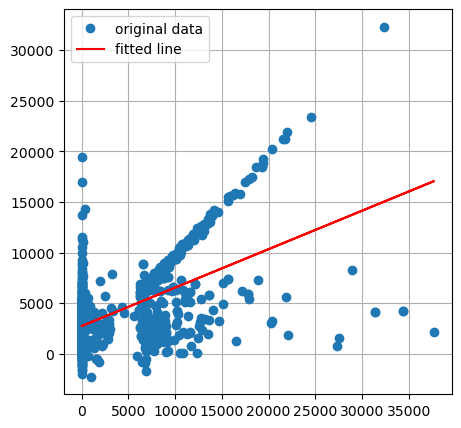

In [109]:
x = results['actual']
y = results['predicted']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.figure(figsize=(5, 5))

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.grid()
plt.show()

## Model Results
The gradient boosting Glove model performs the best of all of the models. This isn't necessarily suprising as Glove embeddings are with good reason an industry standard. It's notable how many of the predictions the model managed to get nearly exactly right. The larger number of posts that have nearly 0 actual votes despite the model thinking they would do better (the dots above x~0 in the above graph) are still clearly interfering with the overall accuracy and causing the trendline to be under the desired x = y sweet spot. 

## Conclusion
While there is some predictive power to these models predicting success of reddit post appears quite hard, something research into other people who have worked on this project confirmed. There is quite a lot of randomness involved in a post blowing up.

Nevertheless, I think that there are some clear conclusions in that both the readability metrics and glove embeddings have predictive power. Additionally, if given a longer time frame to work on this, it would be reasonable to tighten up how the metrics are calculated for reliability. I noticed, for example, that in one case x-ray was counted as 3 seperate words [x,-,ray]. While it remains to be seen how widespread this is, there is likely room for improvement there. 

While the using ngrams rather than single tokens as the basis for the first model may offer some improvement, I am skeptical in that I fear the overlap in ngrams across different posts would be far too sparse to be useful. As such that would probably not be the direction I would take this project further. 

Additionally there is always improvement in terms of modeling techniques used in terms of which models, hyperparameters and data input structuring that offer room for improvement. If both the glove modeling and readability modeling offer predictive power, than combining the two into an ensemble model should represent a further improvement. Additionally it may be worth it to apply the log transformation of the response variable to the other models to see the affect there.

I hope you enjoyed reading my work!